# Object Detection with Transformers
## Detection Transformer (DETR)

### 1. Arhitectura Transformerilor

<p align="right">
  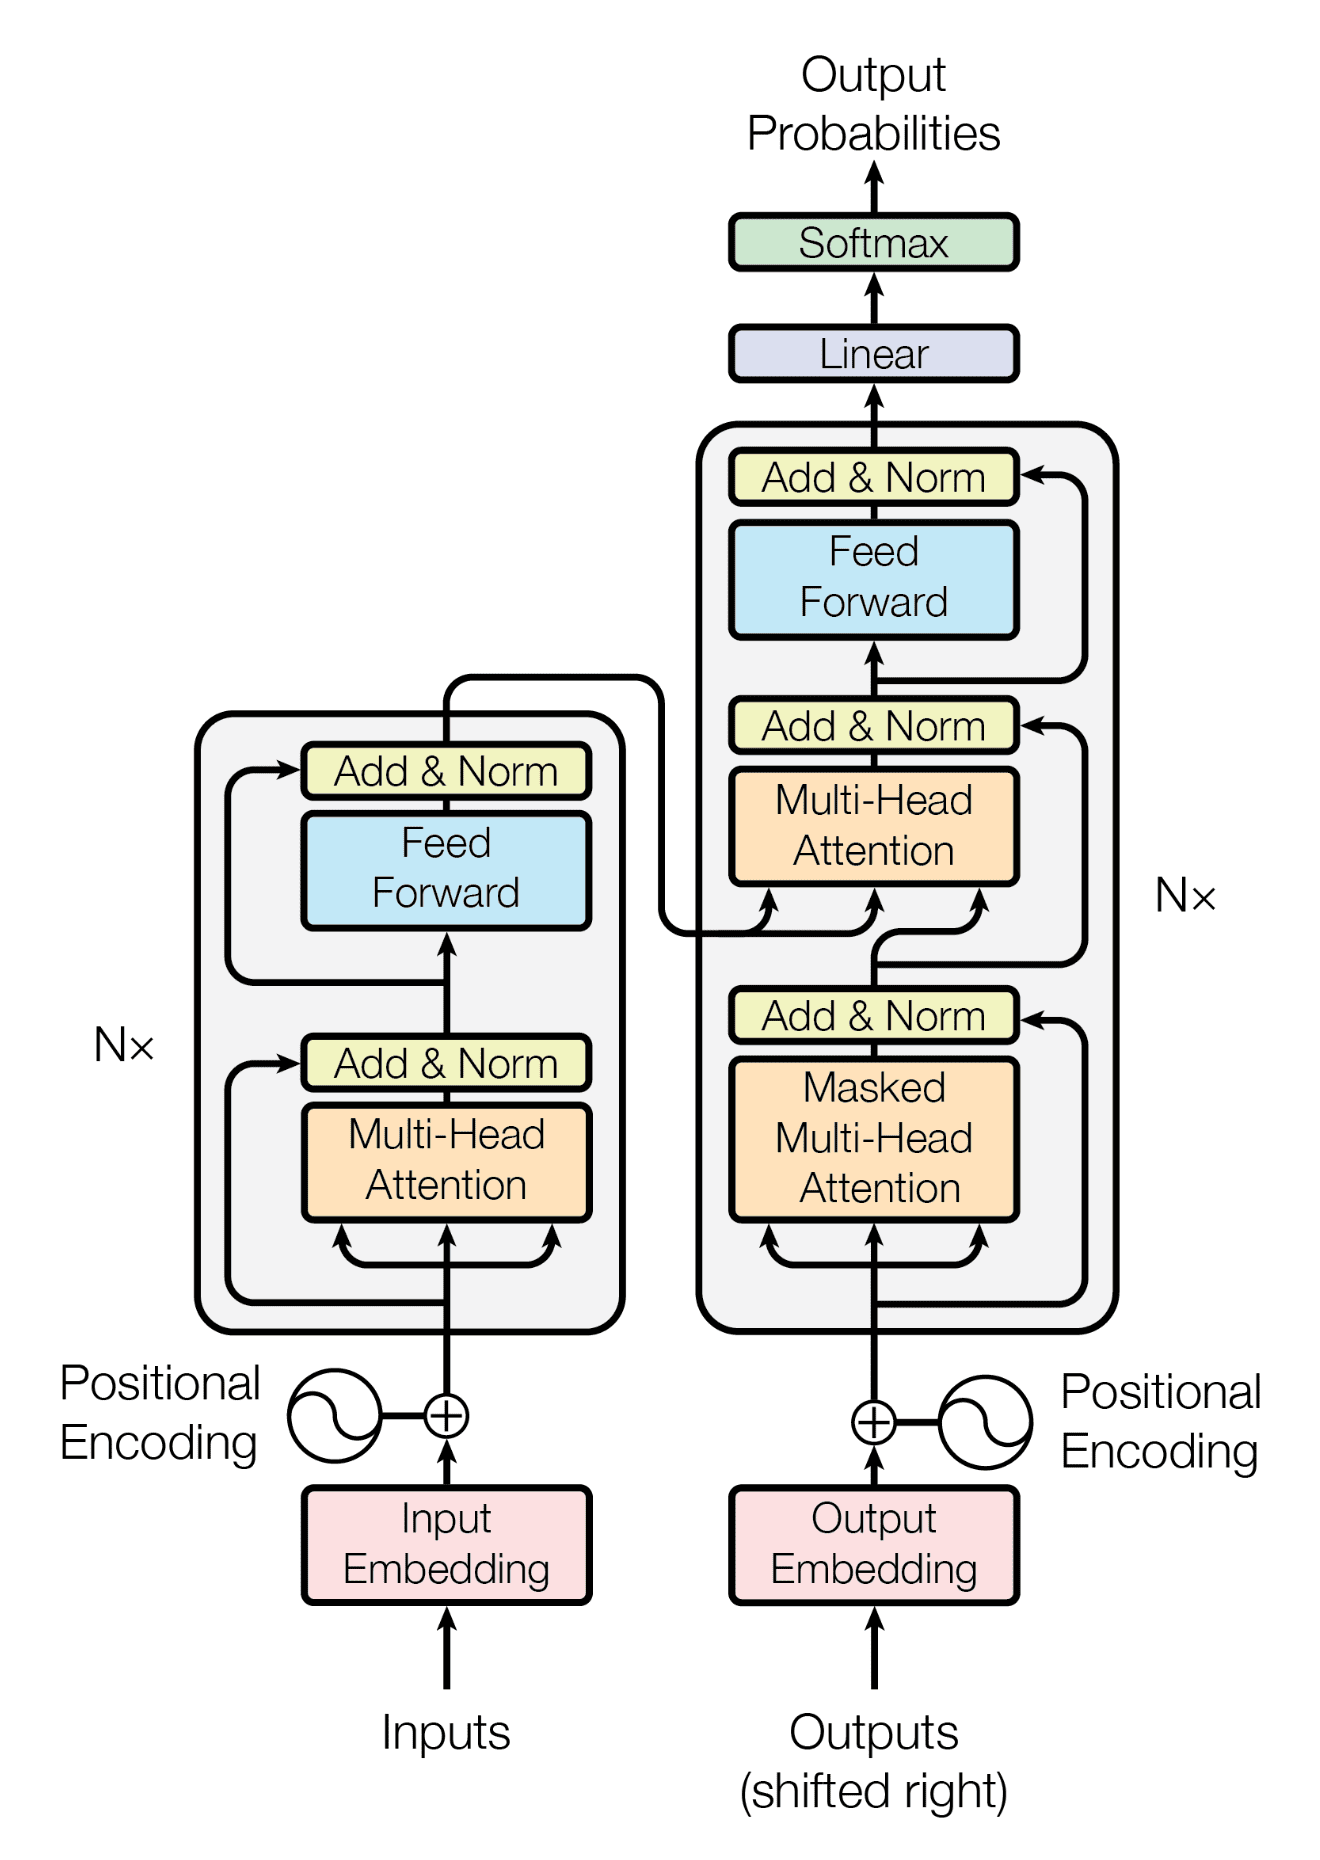
</p>


Arhitectura de trasnformers a fost initial propusă in ["Attention Is All You Need" Vaswani et al.](https://arxiv.org/abs/1706.03762) in 2017, pentru traducerea de texte dintr-o limbă în alta.

Aceasta se bazeaza pe mecanismul de atenție.
Atenția este calculată între 3 vectori:
- Query (Q)
- Key (K)
- Value (V)


<p align="right">
  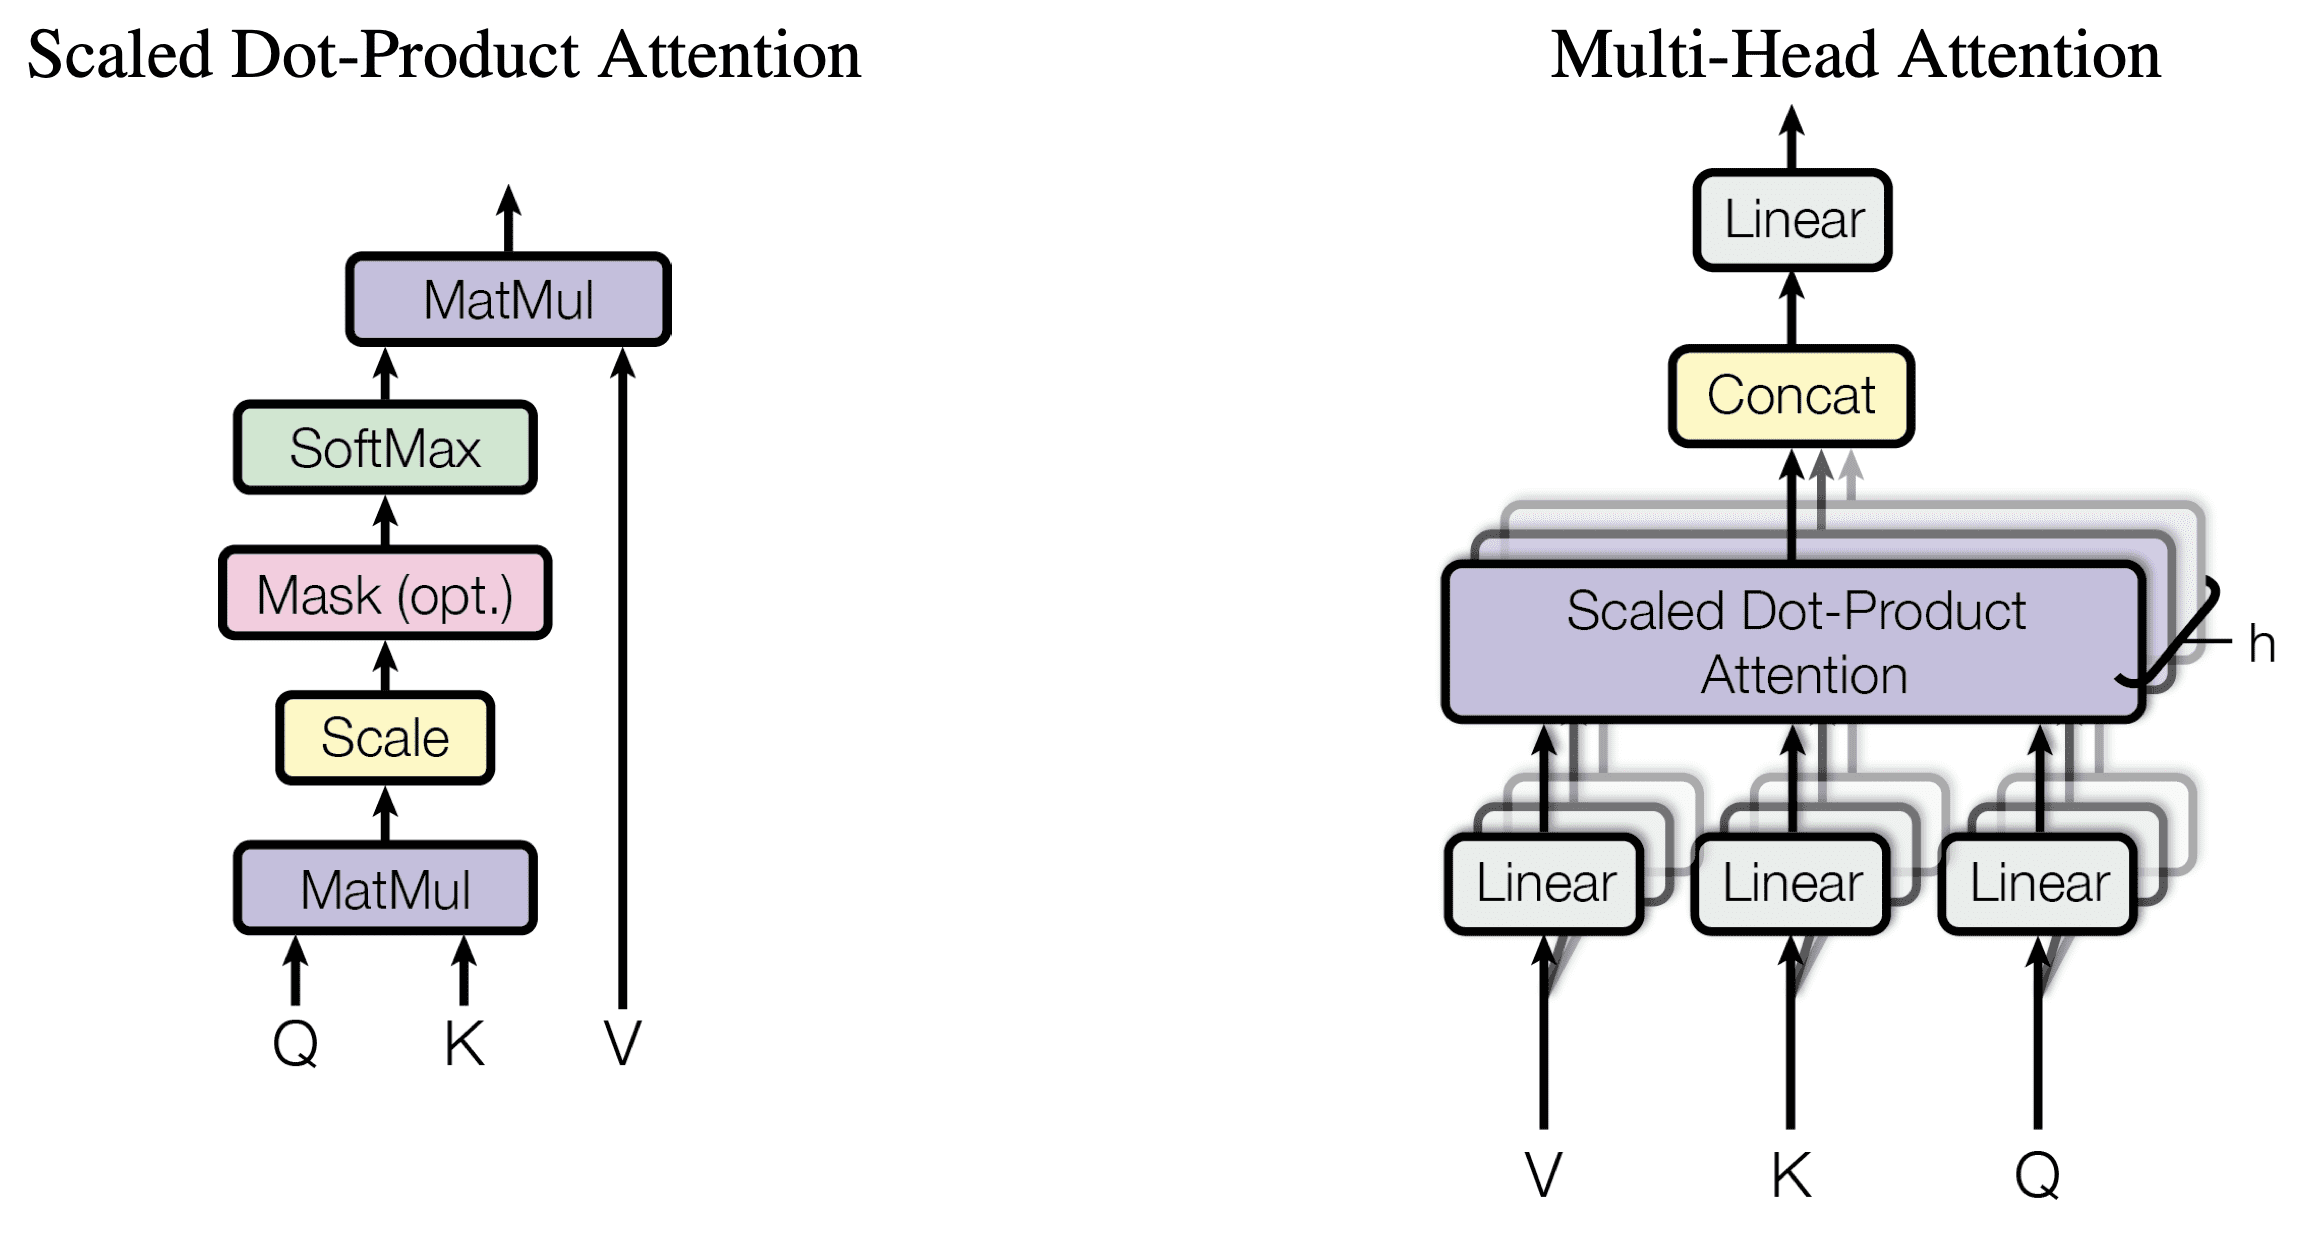


### 2. Arhitectura ResNet

<p align="right">
  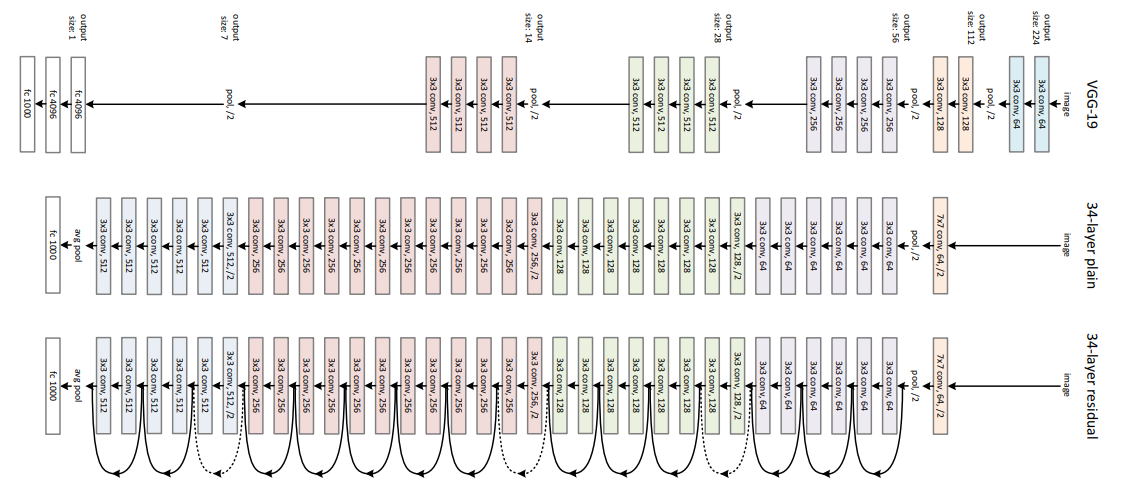
</p>

Arhitectura ResNet a fost propusă în 2015 în ["Deep Residual Learning for Image Recognition" He et al.](https://arxiv.org/abs/1512.03385) și este una dintre cele mai bune arhitecturi pentru prelucrarea de imagini care se bazează pe convoluții.

Aceasta a introdus skip-connections, care au ajutat la propagrarea mai ușoară a gradienților, facând astfel posibilă crearea si antrenarea unor rețele foare deep (cu până la 152 de layers de convoluții in ResNet-152).

Cel mai folosit model este ResNet50, care este suficient de performant relativ la complexitatea sa.

### 3. Arhitectura DETR

<p align="center">
  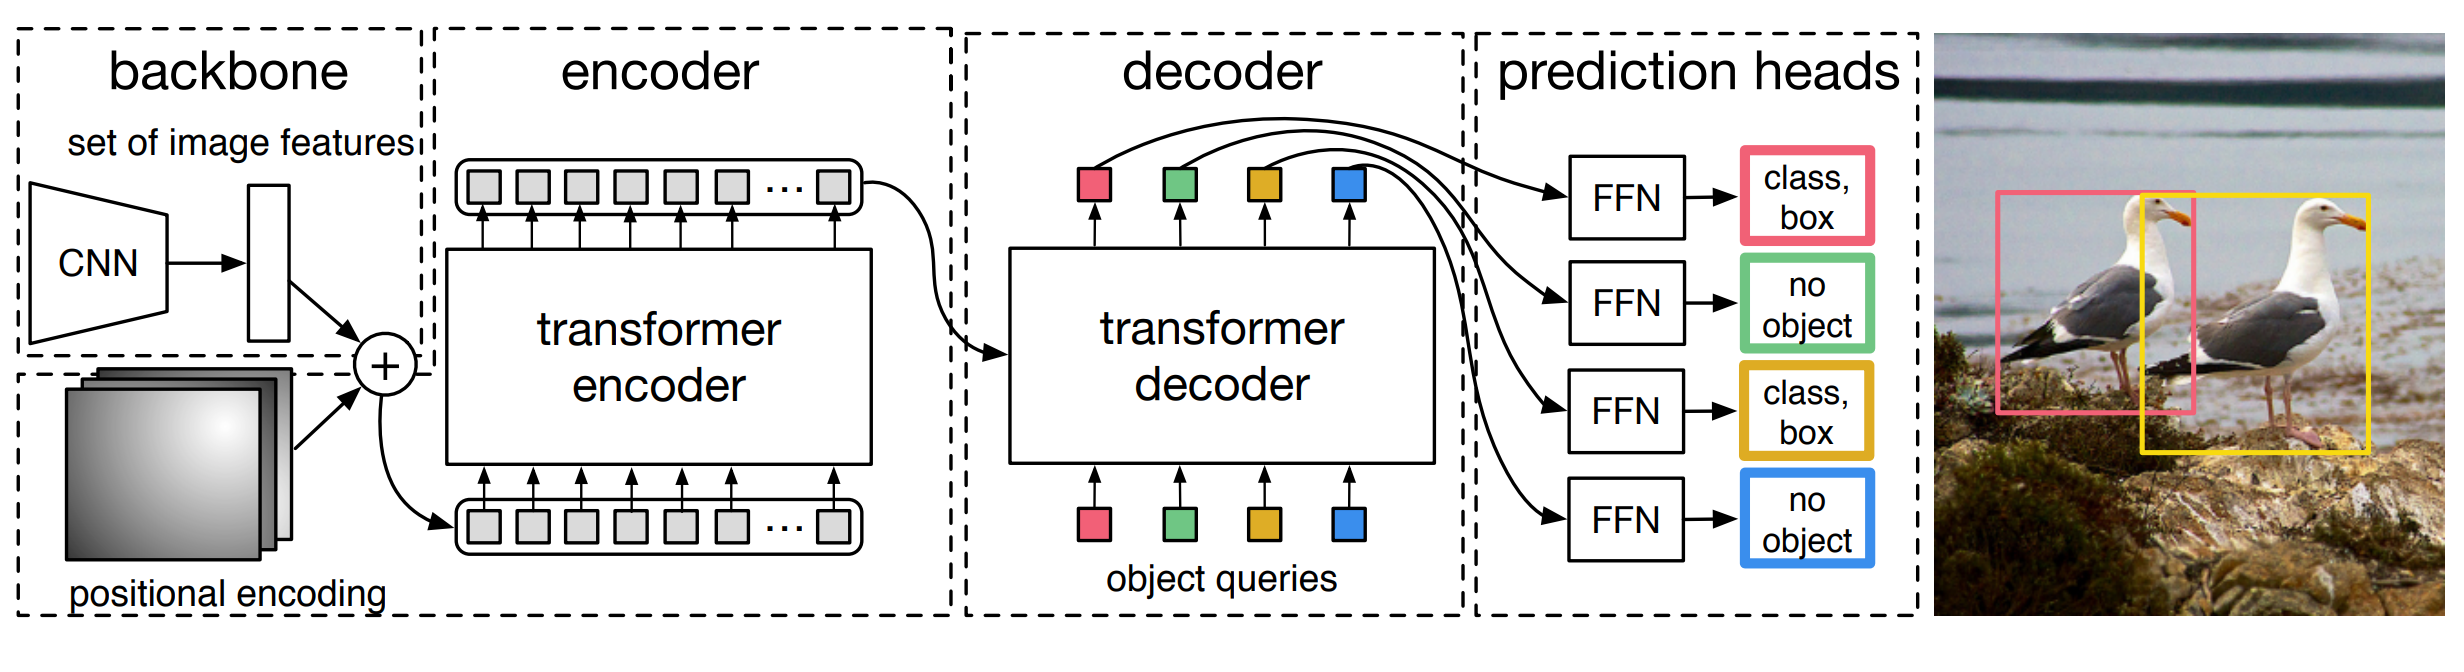

DETR, ["End-to-End Object Detection with Transformers" Carion et al.](https://arxiv.org/abs/2005.12872), este primul model care a reușit să integreze cu succes mecanismul de atenție folosit în transformere în Computer Vision.

Această arhitectură combină un backbone convolutiv (ResNet50 de exemplu) - pentru extragerea de informații din imagine cu un transformer encoder - decoder pentru prelucrarea acestora și extragerea obiectelor de interes (clasa si localizarea lor) in *object queries*.

Modelul este unul foarte simplist, fiind posibilă definirea acestuia in câteva linii de cod.


In [1]:
# instalam torchinfo pentru summary
!pip install torchinfo

In [2]:
# Partea de imports =)
from PIL import Image
import requests
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchinfo import summary
from torchvision.models import resnet50
import torchvision.transforms as T
# extra
import math
import ipywidgets as widgets
from IPython.display import display, clear_output

# daca e available gpu sau nu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"The current device is: {device}")

The current device is: cpu


In [3]:
class DETR(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # Initializam backboneul - un resnet50 din torch
        # Nu avem nevoie de partea de clasificare, deci o eliminam
        self.backbone = resnet50()
        del self.backbone.fc

        # Initializare partea de positional embeddings
        # aici learned, dar pot fi si sine (ca in original transformer)
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

        # Cream un layer de 1x1 convolutii care reduc numarul de channels din backbone
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # Cream partea de transformer encoder -decoder
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # Object queryurile care sunt folosite pentru cross-attention
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # Partea de FFNs care extrag clasa si localizarea din queries
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)


    def forward(self, inputs):
        # Propagam prin partea de backbone, dar nu prin toate layerele
        # Specific pentru resnet50 - prin primele 4
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # Folosim acea 1x1 convolution pentru a reduce numarul de channels
        h = self.conv(x)

        # Calculam partea de positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # Propagam featureurile extrase de backbone impreuna cu
        # positional encodings si de object queries prin transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)

        # La final aplicam FFNs peste rezultatul din transformer
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [4]:
# Incarcam weightsurile preantrenate pe MS-COCO (dataset de benchmark pentru object detection)
# 91 e numarul de clase din coco
detr_model = DETR(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location=device, check_hash=True)
detr_model.load_state_dict(state_dict)

# Punem modelul in evaluation mode
detr_model.eval();
# Printam un summary al modelului
summary(detr_model, input_size=(1, 3, 800, 1200))

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Downloading: "https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth" to /root/.cache/torch/hub/checkpoints/detr_demo-da2a99e9.pth


100%|██████████| 79.3M/79.3M [00:01<00:00, 63.1MB/s]


Layer (type:depth-idx)                                  Output Shape              Param #
DETR                                                    [1, 100, 4]               38,400
├─ResNet: 1-1                                           --                        --
│    └─Conv2d: 2-1                                      [1, 64, 400, 600]         9,408
│    └─BatchNorm2d: 2-2                                 [1, 64, 400, 600]         128
│    └─ReLU: 2-3                                        [1, 64, 400, 600]         --
│    └─MaxPool2d: 2-4                                   [1, 64, 200, 300]         --
│    └─Sequential: 2-5                                  [1, 256, 200, 300]        --
│    │    └─Bottleneck: 3-1                             [1, 256, 200, 300]        75,008
│    │    └─Bottleneck: 3-2                             [1, 256, 200, 300]        70,400
│    │    └─Bottleneck: 3-3                             [1, 256, 200, 300]        70,400
│    └─Sequential: 2-6                  

Întrucât arhitectura de transformere nu mai are acel *bias* al locației ca și convoluțiile, este nevoie de positional embeddings - care sunt adăugate featureurilor extrase cu ajutorul backbone-ului.
În plus, principalul avantaj al acestuia este eliminarea atât a region-proposalului (folosit în two-stage detectors), cât și a ancorelor (folosite în single stage detectors cum ar fi [YOLO](https://arxiv.org/abs/1506.02640) sau [SSD](https://arxiv.org/abs/1512.02325)). Astfel, arhitectura de transformere este capabilă să detecteze un număr fix de obiecte (de obicei 100) dintr-o imagine, cu mențiunea că modelul este în stare să prezică care din acestea sunt de interes și care *no-object* (background). Datorită matcherului folosit, modelul învață să detecteze un obiect o singură dată, astfel că post-processing steps (cum ar fi **NMS**) nu mai sunt necesari.


### 4. Functia de Loss la DETR

Modelul DETR utilizeaza o functie de loss combinata care include atat o componentă pentru clasificare, cat și una pentru localizare (regresie).

#### 4.1.  Hungarian Matcher

Pentru inceput, DETR foloseste un algoritm de potrivire (matching) numit Hungarian Matcher pentru a asocia predictiile modelului cu ground truth.
Acest algoritm minimizeaza costul total al potrivirii intre predictii si ground truths, luand in considerare atat probabilitatile pentru clasificare, cat si erorile de localizare (de exemplu, GIoU - Generalized Intersection over Union sau L1 Loss, pe care le vom vedea mai jos).
De asemenea, folosind acest matcher, modelul este forțat să detecteze un singur obiect o singură dată.




#### 4.2. Loss pentru clasificare

DETR foloseste o functie de loss de tip cross-entropy pentru componenta de clasificare.
Intrucat, pe langa clasele de interes, mai exista acel *no-object* class, se folosește o funcție weighted cross-entropy, cu formula de mai jos:


$$
L_{\text{cls}} = - \sum_{i=1}^{N} w_i \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$


Întrucât, cel mai probabil, într-o imagine vom avea mai multe detecții de tip *no-object* decât orice altă clasă, se folosește un weight de $0.1$ pentru clasa aceasta, în timp ce restul claselor nu vor utiliza weightsuri.





#### 4.3. Loss pentru localizare (regresie)

Pentru componenta de localizare, DETR foloseste o combinatie intre L1 loss si Generalized IoU loss (GIoU loss).

L1 Loss (sau Mean Absolute Error) este o funcție de loss clasică pentru regresie, ca și MSE (Mean Square Error), doar că aici se folosește modulul diferenței în loc de aceasta ridicată la pătrat.

$$
L_{\text{L1}}  = \frac{1}{N} \sum_{i=1}^{N} \left| y_i - \hat{y}_i \right|
$$


GIoU loss este o extensie a IoU care penalizeaza mai bine cazurile in care boxele de delimitare nu se suprapun deloc.

$$
\text{GIoU}(A, B) = \text{IoU}(A, B) - \frac{|C \setminus (A \cup B)|}{|C|}
$$
unde
$$
 \text{IoU}(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$
 și C este cel mai mic box care îi conține atât pe A cât și pe B

$$
L_{\text{giou}} = 1 - \text{GIoU}(A, B)
$$


#### 4.4. Functia de Loss agregata
$$
L_{\text{total}} = \lambda_{\text{cls}} \cdot L_{\text{cls}} + \lambda_{\text{l1}} \cdot L_{\text{box}} + \lambda_{\text{giou}} \cdot L_{\text{giou}}
$$
unde:
- $L_{\text{cls}}$ este loss-ul de clasificare (cross-entropy).
- $L_{\text{l1}}$ este loss-ul de localizare (L1 loss).
- $L_{\text{giou}}$ este loss-ul GIoU.
- $\lambda_{\text{cls}}, \lambda_{\text{box}}, \lambda_{\text{giou}}$ sunt hiperparametri care controlează importanța relativă a fiecărei componente de loss.



### 5. Avantajele DETR

- Arhitectură simplă, fără region proposals sau ancore
- Ușor de exins și pentru segmentare (există DETR Panoptic, care extrage și măștile)
- Generalizare mai bună datorită mecanismului de atenție
- Elimină post-procesările de tipul **NMS**


### 6. Dezavantajele DETR

- Foarte expensive d.p.d.v. computațional din cauza matricii de atenție din encoder
- Convergență foarte lentă (până la 500 epochs pe coco)
- Relativ instabil la începutul trainingului din cauza hungarian matcherului
- Nu prea se descurca bine la detectia de obiecte mici
- Are nevoie de multe date, fiind predispus la overfit din cauza dimensiunii mari

### 7. Inferenta


In [5]:
# Clasele din COCO folosite la antrenare
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Avem nevoie, ca la orice alt model, de normalizarile clasice
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Modelul e antrenat in stitul coco, iar pentru vizualizare il transformam in pascal voc
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

# intrucat detectia bboxurilor este in varianta normalizata (0,1)
# trebuie sa le rescalam la dimensiunea imaginii
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [6]:
def run_inference(im, model, transform):
    # Normalizam inputul si adaugam batchsize de 1
    img = transform(im).unsqueeze(0)
    img = img.to(device)

    # Propagare prin model
    outputs = model(img)

    # Mutam outputul pe cpu pentru viitoare post procesari si afisari
    outputs['pred_logits'] = outputs['pred_logits'].to("cpu")
    outputs['pred_boxes'] = outputs['pred_boxes'].to("cpu")
    return outputs

def filter_outputs(outputs, threshold=0.7):
    # aplicam softmaxul si luam id-ul clasei
    probas, class_ids = outputs['pred_logits'][0].softmax(-1).max(-1)

    # dam remove la no-object class
    mask = class_ids != outputs["pred_logits"].shape[-1] - 1
    pred_boxes = outputs["pred_boxes"][0][mask]
    pred_logits = outputs["pred_logits"][0][mask].softmax(-1)

    # filtram dupa thresholdul pentru probabilitati
    keep = pred_logits.max(-1).values > threshold
    pred_logits = pred_logits[keep]

    # Convertim bboxurile din (0, 1) la rezolutia imaginii
    bboxes_scaled = rescale_bboxes(pred_boxes[keep], im.size)
    return pred_logits, bboxes_scaled

In [7]:
def plot_results(pil_img, prob, boxes):
    # Afisam imaginea origilana impreuna cu detectia modelului
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='green', linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [8]:
url = "https://farm4.staticflickr.com/3286/3143017888_b18f27ed58_z.jpg"
im = Image.open(requests.get(url, stream=True).raw)
outputs = run_inference(im, detr_model, transform)


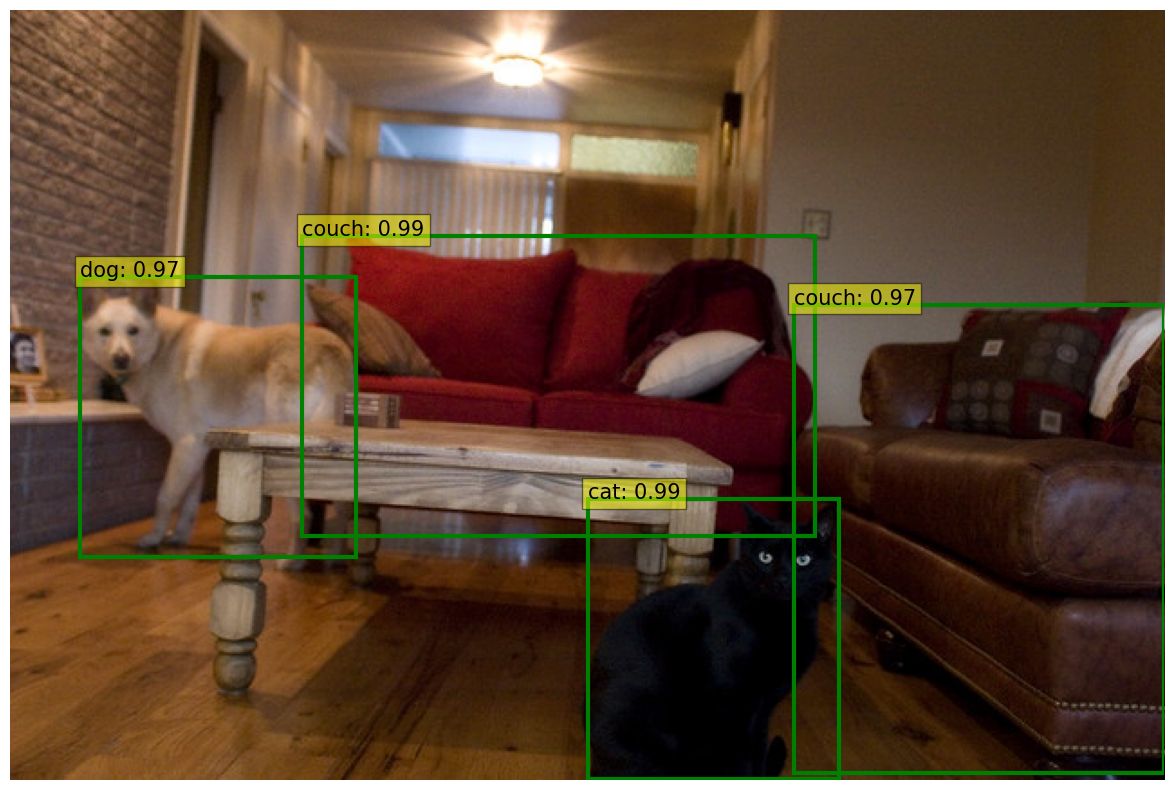

In [10]:
scores, boxes = filter_outputs(outputs, 0.6)
plot_results(im, scores, boxes)

In [11]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)
outputs = run_inference(im, detr_model, transform)


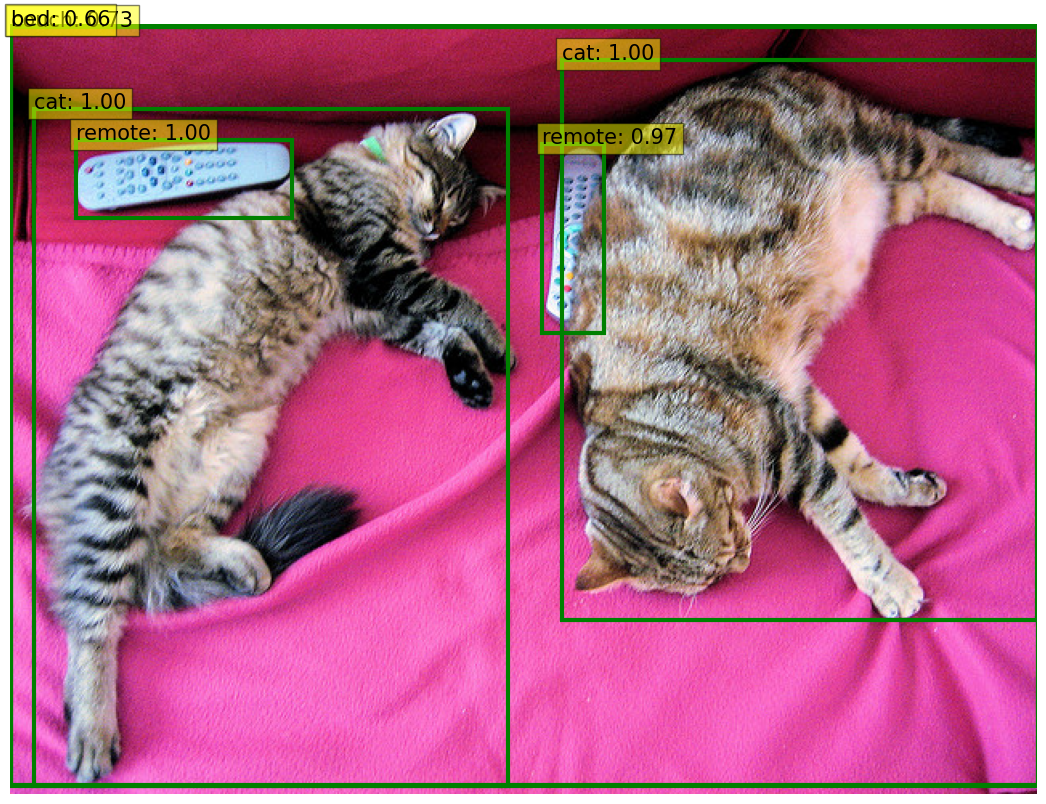

In [12]:
scores, boxes = filter_outputs(outputs, 0.6)
plot_results(im, scores, boxes)

### 8. Attention Visualizer

In [13]:
# Aici e definita o clasa pentru vizualizare
class AttentionVisualizer:
    def __init__(self, model, transform):
        self.model = model
        self.transform = transform

        self.url = ""
        self.cur_url = None
        self.pil_img = None
        self.tensor_img = None

        self.conv_features = None
        self.enc_attn_weights = None
        self.dec_attn_weights = None

        self.setup_widgets()

    def setup_widgets(self):
        self.sliders = [
            widgets.Text(
                value='http://images.cocodataset.org/val2017/000000039769.jpg',
                placeholder='Type something',
                description='URL (ENTER):',
                disabled=False,
                continuous_update=False,
                layout=widgets.Layout(width='100%')
            ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='X coordinate', value=0.72,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')
                        ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='Y coordinate', value=0.40,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')),
            widgets.Checkbox(
              value=False,
              description='Direction of self attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          ),
            widgets.Checkbox(
              value=True,
              description='Show red dot in attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          )
        ]
        self.o = widgets.Output()

    def compute_features(self, img):
        model = self.model
        # use lists to store the outputs via up-values
        conv_features, enc_attn_weights, dec_attn_weights = [], [], []

        hooks = [
            model.backbone[-2].register_forward_hook(
                lambda self, input, output: conv_features.append(output)
            ),
            model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
                lambda self, input, output: enc_attn_weights.append(output[1])
            ),
            model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
                lambda self, input, output: dec_attn_weights.append(output[1])
            ),
        ]
        # propagate through the model
        outputs = model(img)

        for hook in hooks:
            hook.remove()

        # don't need the list anymore
        # print(conv_features)
        self.conv_features = conv_features[0]
        print(self.conv_features['0'].tensors.shape)
        self.dec_attn_weights = dec_attn_weights[0]
        # get the HxW shape of the feature maps of the CNN
        shape = self.conv_features['0'].tensors.shape[-2:]
        # and reshape the self-attention to a more interpretable shape
        self.enc_attn_weights = enc_attn_weights[0].reshape(shape + shape)

    def compute_on_image(self, url):
        if url != self.url:
            self.url = url
            self.pil_img = Image.open(requests.get(url, stream=True).raw)
            # mean-std normalize the input image (batch-size: 1)
            self.tensor_img = self.transform(self.pil_img).unsqueeze(0)
            self.compute_features(self.tensor_img)

    def update_chart(self, change):
        with self.o:
            clear_output()

            # j and i are the x and y coordinates of where to look at
            # sattn_dir is which direction to consider in the self-attention matrix
            # sattn_dot displays a red dot or not in the self-attention map
            url, j, i, sattn_dir, sattn_dot = [s.value for s in self.sliders]

            fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 4))
            self.compute_on_image(url)

            # convert reference point to absolute coordinates
            j = int(j * self.tensor_img.shape[-1])
            i = int(i * self.tensor_img.shape[-2])

            # how much was the original image upsampled before feeding it to the model
            scale = self.pil_img.height / self.tensor_img.shape[-2]

            # compute the downsampling factor for the model
            # it should be 32 for standard DETR and 16 for DC5
            sattn = self.enc_attn_weights
            fact = 2 ** round(math.log2(self.tensor_img.shape[-1] / sattn.shape[-1]))

            # round the position at the downsampling factor
            x = ((j // fact) + 0.5) * fact
            y = ((i // fact) + 0.5) * fact

            axs[0].imshow(self.pil_img)
            axs[0].axis('off')
            axs[0].add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))

            idx = (i // fact, j // fact)

            if sattn_dir:
                sattn_map = sattn[idx[0], idx[1], ...]
            else:
                sattn_map = sattn[..., idx[0], idx[1]]

            axs[1].imshow(sattn_map.detach().cpu(), cmap='cividis', interpolation='nearest')
            if sattn_dot:
                axs[1].add_patch(plt.Circle((idx[1],idx[0]), 1, color='r'))
            axs[1].axis('off')
            axs[1].set_title(f'self-attention{(i, j)}')

            plt.show()

    def run(self):
      for s in self.sliders:
          s.observe(self.update_chart, 'value')
      self.update_chart(None)
      url, x, y, d, sattn_d = self.sliders
      res = widgets.VBox(
      [
          url,
          widgets.HBox([x, y]),
          widgets.HBox([d, sattn_d]),
          self.o
      ])
      return res

In [14]:
# pentru asta trebuie sa descarcam modelul original care foloseste
# atfel de positional encodings decat pe cele pe care le folosim noi

# stergem modelul din memorie inainte sa nu folosim atat de multe resurse
try:
    del detr_model
except NameError:
    print("Modelul nu a fost creat")

model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval()


Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


100%|██████████| 159M/159M [00:01<00:00, 100MB/s]


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [15]:
w = AttentionVisualizer(model, transform)
w.run()

Acum ne putem juca cu sliderele sau putem sa punem alta imagine acolo cu un url.
In partea din dreapta e activarea self-attention-ului, iar in stânga imaginea de referință.

### 9. Deformable DETR

Având în vedere problemele cunoscute ale modelului DETR, care limitau folosirea acestuia, a fost propus mecanismul de deformable attention în ["Deformable DETR: Deformable Transformers for End-to-End Object Detection"](https://arxiv.org/abs/2010.04159).

Acesta aduce câteva îmbunătățiri asupra arhitecturii originale, făcând-o mai eficientă și mai precisă, prin înlocuirea attentionului global cu deformable attention.

Practic, în loc să se calculeze attention între fiecare 2 tokens (deci o complexitate pătratică), fiecare token ”va fi atent” doar la alți câțiva tokens.

De asemenea, o dată cu eliminearea acelui cost pătratic care venea din matricea de atentie globala, headul de detecție poate folosi Multi-Scale Feature - adică featureuri de la diverse nivele din ResNet, ceea ce ii confera o precizie mult mai buna la bounding boxurile micute.

Modificare asta a îmbunătățit și convergența modelului, fiind suficiente doar 50 de epochs pentru a antrenare.